#### Goal of this study is to compile a regressor model to understand the most significant features contributing to the estimation of household electricity consumption

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.tree import plot_tree



nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
nsm['month'] = pd.to_datetime(nsm['month'])
nsm['month_of_the_year'] = nsm['month'].dt.month

In [57]:
data = nsm.merge(wave_1_houseinfo, on= 'household_ID', how= 'left')
data = data[['consumption', 'month_of_the_year','no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'built_year_of_the_house', 'type_of_house',
       'no_of_storeys', 'floor_area', 'no_of_household_members',
       'charged_method_for_rent_for_electricity',
       'is_there_business_carried_out_in_the_household',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electricity_meter']].copy()

In [58]:
df_encoded = data.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)
data = pd.DataFrame(scaled_data, columns=df_encoded.columns)
data.dropna(inplace=True)

In [59]:
X = data.drop(columns=['consumption'])
y = data['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

def evaluate(y_true, y_pred, model_name):
    print(f"\n📊 {model_name}")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred):.2f}")   # to Penalizes larger errors more heavily due to squaring.
    print(f"R²:   {r2_score(y_true, y_pred):.3f}")

tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
evaluate(y_test, y_pred_tree, "Decision Tree Regressor")

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate(y_test, y_pred_rf, "Random Forest Regressor")

xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost Regressor")


📊 Decision Tree Regressor
MAE:  0.38
RMSE: 0.50
R²:   0.809

📊 Random Forest Regressor
MAE:  0.31
RMSE: 0.34
R²:   0.870

📊 XGBoost Regressor
MAE:  0.29
RMSE: 0.34
R²:   0.871


#### Feature importance

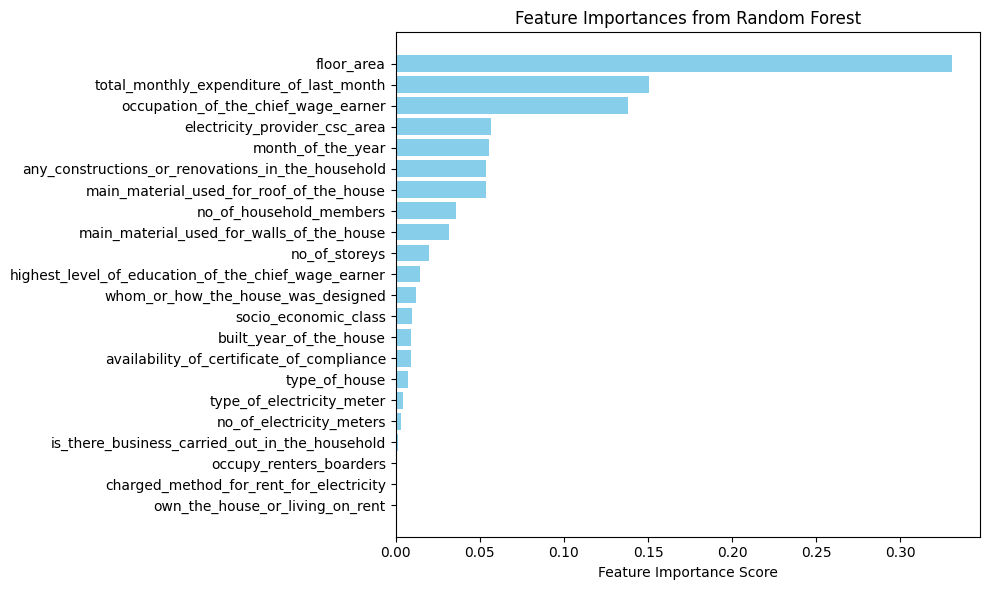

In [63]:
model = rf

importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(features[indices], importances[indices], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

##### Feature engineering: exploring other survey waves and tables

In [77]:
generation = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_electricity_generation_water_heating_cooking.csv')
generation = generation[['have_backup_generator', 'generate_electicity_using_solar_energy', 'method_of_receiving_water', 'water_heating_method_for_bathing', 'source_of_energy_for_boiling_drinking_water', 'boil_water_before_drinking', 'electricity_from_national_grid_used_for_cooking']].copy()
demographics = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_demographics.csv')
hours = demographics.groupby('household_ID')['no_of_hours_stayed_at_home_during_last_week'].sum()
hours_stayed = pd.DataFrame(hours)


'''
use dataframes:
1. generation
2. hours_stayed

'''


In [90]:
ac = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_ac_roster.csv')
ac.columns

Index(['household_ID', 'room_ID', 'ac_ID', 'type_of_the_ac',
       'is_the_ac_inverter_or_not', 'is_room_fully_sealed',
       'wattage_of_the_ac', 'btu_of_the_ac',
       'no_of_hours_ac_was_on_during_daytime_last_week',
       'no_of_hours_ac_was_on_during_night_last_week'],
      dtype='object')

In [93]:
hours = ac.groupby('household_ID')[['no_of_hours_ac_was_on_during_daytime_last_week', 'no_of_hours_ac_was_on_during_night_last_week']].sum()
ac_hours = pd.DataFrame(hours)
ac_hours

,no_of_hours_ac_was_on_during_daytime_last_week,no_of_hours_ac_was_on_during_night_last_week
household_ID,,
ID0012,0.0,45.0
ID0014,0.0,0.0
ID0018,0.0,56.0
ID0025,0.0,0.0
ID0039,24.0,24.0
...,...,...
ID3950,0.0,2.0
ID4015,0.0,0.0
ID4026,0.0,2.0


In [76]:
generation['electricity_from_national_grid_used_for_cooking'].value_counts()

electricity_from_national_grid_used_for_cooking
No     2494
Yes    1569
Name: count, dtype: int64

In [75]:
generation['electricity_from_national_grid_used_for_cooking'].unique()

array(['Yes', 'No'], dtype=object)